<a href="https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL-Chapters/blob/main/Beginner_Pouria_TrainingStrategyandComponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Strategy and Components

## Part 1: Introduction

In [ ]:
# Installing required libraries.
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
#BJE: Should we set a specific version so it doesn't break in the future?

     |████████████████████████████████| 542kB 14.9MB/s 
     |████████████████████████████████| 204kB 23.9MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 


In [ ]:
# Importing the required python types for type hinting
# Turning off the notebook warnings

from typing import List, Tuple, Dict, Union, Callable, Iterable
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
# Set random seeds for deterministic programming

import torch
import numpy as np
import monai
import random

def Determine_seed():
  random_seed = 1000
  np.random.seed(random_seed)
  os.environ['PYTHONHASHSEED'] = str(random_seed)
  random.seed(random_seed)
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  monai.utils.misc.set_determinism(seed=random_seed)

In [ ]:
# Selecting the processor device. Make sure your colab runtype is set to GPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Downloading the original data from a shortened version of the following link:
# https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/
# f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded.

import os

# BJE: remove sample data that colab always includes
!rm -rf ./sample_data/

# BJE: I think we should make our own copy so that if the current owner decides to stop allowing acess, we are still alive
# BJE: And if we put it on google drive, it will also likely download faster to colab...
# BJE: The link for my google drive copy is: 
if not os.path.isdir('chest_xray'):
  !gdown 'https://drive.google.com/uc?&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2'
  # was https://bit.ly/3gm0b73
  !unzip -q chest_xray.zip
#  os.remove('chest_xray.zip')

Downloading...
From: https://drive.google.com/uc?&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2
To: /content/chest_xray.zip
1.24GB [00:17, 70.5MB/s]


In [ ]:
# Collecting all image paths, along with their associated labels and sets

def Collect_imageinfo_list(images_dirpath: str) -> List:
  """
  Return a list of information tuples for all images, where each information 
  tuple includes the associated path, label, and set for each image.
  Parameters:
    - images_dirpath (str): Path to the directory including all images.
    - imageinfo_list (List): a list of (file_path, file_label, file_set) 
    for each image file.
  """
  imageinfo_list = list()
  for root, dirs, files in os.walk(images_dirpath):
    for file in files:
        if file.lower().endswith('.jpeg') or file.lower().endswith('.jpg'):
          file_path = os.path.join(root, file)
          dir_path = os.path.dirname(file_path)
          file_label = dir_path.split('/')[-1]
          file_set = os.path.dirname(dir_path).split('/')[-1]
          imageinfo_list.append((file_path, file_label, file_set))
  return imageinfo_list

imageinfo_list = Collect_imageinfo_list('chest_xray')

train_imageinfo_list = [imageinfo for imageinfo in imageinfo_list 
                        if imageinfo[2]=='train']
train_pneumonia_count = len([imageinfo for imageinfo in train_imageinfo_list 
                             if imageinfo[1]=='PNEUMONIA'])
train_normal_count = len([imageinfo for imageinfo in train_imageinfo_list 
                          if imageinfo[1]=='NORMAL'])
test_imageinfo_list = [imageinfo for imageinfo in imageinfo_list 
                       if imageinfo[2]=='test']
test_pneumonia_count = len([imageinfo for imageinfo in test_imageinfo_list 
                            if imageinfo[1]=='PNEUMONIA'])
test_normal_count = len([imageinfo for imageinfo in test_imageinfo_list 
                         if imageinfo[1]=='NORMAL'])

#BJE: fixed typo: 'Nomral -> Normal' here and 2 lines down
print(f'Number of images in the training set: {len(train_imageinfo_list)} --> \
Pneumonia: {train_pneumonia_count} - Normal: {train_normal_count}')
print(f'Number of images in the test set: {len(test_imageinfo_list)} --> \
Pneumonia: {test_pneumonia_count} - Normal: {test_normal_count}')

Number of images in the training set: 5232 --> Pneumonia: 3883 - Normal: 1349
Number of images in the test set: 624 --> Pneumonia: 390 - Normal: 234


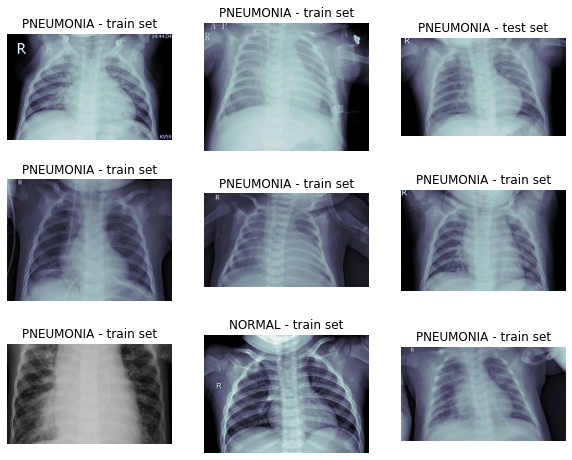

In [ ]:
# Plotting sample images from the original data
import matplotlib.pyplot as plt
from skimage.io import imread

def Plot_sample_images():
  """
  Plot 9 sample images from the imaging dataset, while printing their 
  associated labels and sets.
  """
  # For deterministic programming
  Determine_seed()
  
  fig, axes = plt.subplots(3, 3, figsize=(10, 8))
  random_imagesinfo_items = random.choices(imageinfo_list, k=9)
  for i, imageinfo in enumerate(random_imagesinfo_items):
    image = imread(imageinfo[0])
    axes[i//3, i%3].imshow(image, cmap='bone')
    axes[i//3, i%3].axis('off')
    axes[i//3, i%3].set_title(f'{imageinfo[1]} - {imageinfo[2]} set')
  plt.show()

Plot_sample_images()

# Probably should have some text of what the output should look like and what it means after many/most cells

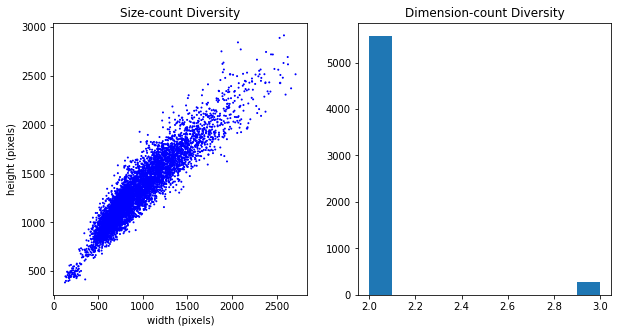

In [ ]:
# Investigating the size of the images we have

def Investigate_image_arrays():
  """
  Plot the size-count and dimension-count diversity plots for image arrays.
  """
  image_arrayshape_list = [imread(imageinfo[0]).shape 
                           for imageinfo in imageinfo_list]
  image_size_list = [(shape[0], shape[1]) for shape in image_arrayshape_list]
  image_dimcount_list = [len(shape) for shape in image_arrayshape_list]
  image_size_set = set(image_size_list)
  unique_rows = [size[0] for size in image_size_set],
  unique_columns = [size[1] for size in image_size_set],
  unique_size_counts = [image_size_list.count(size) for size in image_size_set]
  # Plotting:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].scatter(x=unique_rows, y=unique_columns, 
                  s=unique_size_counts, c='blue')
  axes[0].set_title('Size-count Diversity')
  axes[0].set_xlabel('width (pixels)')
  axes[0].set_ylabel('height (pixels)')
  axes[1].hist(image_dimcount_list);
  axes[1].set_title('Dimension-count Diversity');

Investigate_image_arrays()

As you can see, nearly all images are 2D (why are there 3D images?) but there is a tremendous range of image sizes in terms of pixels. Most AI networks want images that are similar, particularly in terms of image size, unless the focus is on pieces of the image (e.g. find all the nuclei in this image). That means we need to do some image processing to make the images have the same dimensions.

In [ ]:
# Building datasets and dataloaders using MONAI

from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              AddChannelD, LambdaD, ToTensorD, RepeatChannelD)
from monai.data import Dataset, DataLoader
from monai.utils.misc import first

def Collater(data: List) -> Dict:
  """
  A collater function for MONAI dictionary-type datasets.
  We use this collater as MONAI default collate function may result in some
  weird errors occasionally. This may have nee corrected at the time you read
  this notebook, so feel free to import mona.data.list_data_collate and pass it
  to the Build_dataloaders function instead of the Collater function.
  Parameters:
    - data (List): a list of input data to be batched from the dataset.
    - batched_data (Dict): a dictionary of batched input data.
  """
  batch_images = [s['image'] for s in data]
  batch_labels = [s['label'] for s in data]
  images = torch.stack(batch_images, axis=0)
  labels = torch.stack(batch_labels, axis=0)
  labels = labels.to(torch.int64)
  labels = labels.squeeze(-1)
  batched_data = {'image': images, 'label': labels}
  return batched_data

def Build_dataloaders(train_imageinfo_list: List = train_imageinfo_list, 
                      test_imageinfo_list: List = test_imageinfo_list, 
                      Collater: Callable = Collater,
                      image_size: int = 224,
                      augment_train_data: bool = False,
                      fct_to_train: float = 1.0,
                      fct_to_valid: float = 0.5) -> DataLoader:
  """
  Build and return train and test dataloaders.
  Parameters:
    - train_imageinfo_list (list): a list of (file_path, file_label, file_set) 
    for each image file in the training set.
    - test_imageinfo_list (list): a list of (file_path, file_label, file_set) 
    for each image file in the test set.
    - Collator (Callable): a collator function for building the dataloaders.
    - fct_to_train (float): fraction of training data to make available for 
    building the training data loader.
    - image_size (int): the output image size for the dataloader, which would be
    (image_size * image_size). BJE: This is where we make the image size consistent. 
    We use 224 because that is the size that the pre-trained network expects.
    - fct_to_valid (float): fraction of the test data to use as the validation
    set (and not the test set).
    - train_loader (DataLoader): dataloader for the training set.
    - test_loader (DataLoader): dataloader for the test set.
  """
  
  # for deterministic programming
  Determine_seed()
  def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

  label_dict = {'PNEUMONIA':1, 'NORMAL':0}
  train_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]} 
                     for imageinfo in train_imageinfo_list]
  test_data_list = [{'image': imageinfo[0], 'label':label_dict[imageinfo[1]]} 
                    for imageinfo in test_imageinfo_list]
  
  # Shuffling the data before fractioning it
  # Note: We assume that each datapoint in the test_data_list belongs to 
  # a seprate patient.
  random.shuffle(train_data_list)
  random.shuffle(test_data_list)
  
  # Using fractions of data
  P_train_list = [x for x in train_data_list if x['label']==1]
  N_train_list = [x for x in train_data_list if x['label']==0]
  P_test_list = [x for x in test_data_list if x['label']==1]
  N_test_list = [x for x in test_data_list if x['label']==0]
  touse_train_data = P_train_list[:int(len(P_train_list)*fct_to_train)] + \
  N_train_list[:int(len(N_train_list)*fct_to_train)]
  touse_valid_data = P_test_list[:int(len(P_test_list)*fct_to_valid)] + \
  N_test_list[:int(len(N_test_list)*fct_to_valid)]
  touse_test_data = [x for x in test_data_list if x not in touse_valid_data]

  # Building MONAI transforms
  Aug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim==3 else x),
          AddChannelD(keys="image"),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
          RandZoomD(keys="image", mode="bilinear"),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3)
          ])
  NoAug_transforms = Compose([
          LoadImageD(keys="image"),
          EnsureChannelFirstD(keys="image"),
          LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim==3 else x),
          AddChannelD(keys="image"),
          ResizeD(keys="image", spatial_size=(image_size, image_size)),
          NormalizeIntensityD(keys="image"),
          ToTensorD(keys=["image", "label"]),
          RepeatChannelD(keys="image", repeats=3)
          ])
  
  # Building MONAI datasets
  if augment_train_data:
    train_dataset = Dataset(touse_train_data, transform=Aug_transforms)
  else:
    train_dataset = Dataset(touse_train_data, transform=NoAug_transforms)
  valid_dataset = Dataset(touse_valid_data, transform=NoAug_transforms)
  test_dataset = Dataset(touse_test_data, transform=NoAug_transforms)
  
  # Building MONAI dataloaders
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                            num_workers=1, collate_fn=Collater,
                            worker_init_fn=worker_init_fn)
  valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, 
                            num_workers=1, collate_fn=Collater,
                            worker_init_fn=worker_init_fn)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, 
                           num_workers=1, collate_fn=Collater,
                           worker_init_fn=worker_init_fn)
  return train_loader, valid_loader, test_loader

# Testing the shape and dtype for a sample batche from the training dataloader:

train_loader, valid_loader, test_loader = Build_dataloaders()
sample_batch = first(train_loader)
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['label'] shape: {sample_batch['label'].shape}")
print(f"batch['label'] dtype: {sample_batch['label'].dtype}")

batch['image'] shape: torch.Size([8, 3, 224, 224])
batch['image'] dtype: torch.float32
batch['label'] shape: torch.Size([8])
batch['label'] dtype: torch.int64


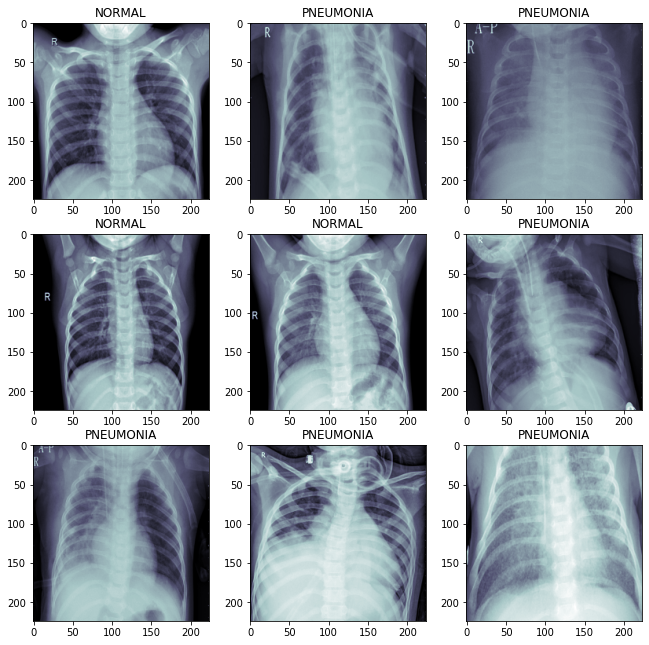

In [ ]:
# Plotting sample images from the dataloaders.

def Plot_sample_dataloader_images(dataloader):
  """
  Plot 9 sample images from either the training or test dataloaders.
  """
  # For deterministic programming
  Determine_seed()
  
  label_tensor_dict = {1:'PNEUMONIA', 0:'NORMAL'}
  dataiter = iter(dataloader)
  image_tensor_list = list()
  label_list = list()
  fig, axes = plt.subplots(3, 3, figsize=(11, 11))
  for i in range(9):
    data = dataiter.next()
    image_batch, label_batch = data['image'], data['label']
    axes[i//3, i%3].imshow(image_batch[0][0], cmap='bone')
    axes[i//3, i%3].set_title(label_tensor_dict[int(label_batch[0])])

Plot_sample_dataloader_images(train_loader)

This shows that we still have images in our data, though now all are set at 224x224.

## Part 2: Anatomy of a deep learning model


In [ ]:
# Building a resnet model

import torchvision.models as models
import torch.nn as nn
import shutil

def Build_model(arch: str = 'vgg16', pretrained: bool = False)-> Callable:
  """
  Build a resnet model using Pytorch.
  Parameters:
    - arch (str): baseline architecture of the model that could be called using
    torchvision.models.arch command.
    - pretrained (bool): whether or not to use pretrained weights.
    - model (Callable): built pytroch module.
  """
  # For deterministic programming
  Determine_seed()
  
  # Loading a model with the user-specified architecture from torch
  if 'vgg' not in arch and 'alexnet' not in arch and 'resnet' not in arch:
    raise ValueError ('Only resnet, vgg or alexnet models can be loaded!')
  else:
    try:
      model = eval(f'models.{arch}(pretrained={pretrained})')
    except:
      raise ValueError ('The name of the architecture is not valid!')

  # Replacing the final fully conntected layer of the model
  # Please note that we have two calsses, and therefore, the final FC layer 
  # will have two final nodes
  # The VGG network has not FC layer, so we directly change its final layer
  if 'vgg' in arch or 'alexnet' in arch:
    model.classifier._modules['6'] = nn.Linear(4096, 2)
  else: 
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(num_in_features, 2)

  # Initializing the weights of the model if not pretrained
  if not pretrained:
    def Weights_init(m: Callable):
      """
      Initialize the weights of a given torch model.
      Parameters:
        m (Callable): any pytorch model.
      """
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
      if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)
    model = model.apply(Weights_init)

  return model

In [ ]:
# A function to evaluate a model's performance on the test_loader

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

def Evaluate_model(model: Callable, 
                   test_loader: Iterable = test_loader,
                   plot_cm: bool = True) -> float: 
  """
  Evaluate a given model's performance on the test set.
  Parameters:
    model (Callable): the pytorch model to be evaluated.
    test_loader (Iterable): test dataloader to be used as the test data.
    plot_cm (bool): whether or not to plot a confusion matrix.
    accuracy (float): accuracy of the model.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  labels_list = list()
  preds_list = list()
  with torch.no_grad():
    for batch in tqdm(test_loader):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      outputs = model(inputs)
      preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
      labels_list.append(labels)
      preds_list.append(preds) 
    all_labels = torch.cat(labels_list).cpu()
    all_preds = torch.cat(preds_list).cpu()
    accuracy = (all_preds == all_labels).sum().item()/len(all_labels)
  
  if plot_cm:
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix - accuracy: {accuracy:.2f}')
    ax.xaxis.set_ticklabels(['Pneumonia', 'Normal']);
    ax.yaxis.set_ticklabels(['Pneumonia', 'Normal']);
  
  return accuracy

In [ ]:
# Plotting the structure for a Vgg11 model

from torchsummary import summary
non_trained_vgg16 = Build_model(arch='vgg16', pretrained=False).to(device)
summary(non_trained_vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

  0%|          | 0/39 [00:00<?, ?it/s]

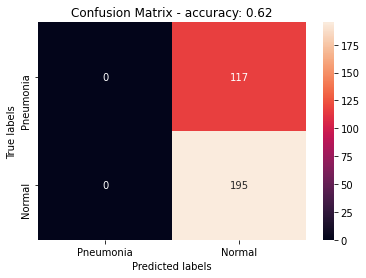

In [ ]:
# Evaluating the performance of a non-trained model

_ = Evaluate_model(non_trained_vgg16)

# Model Evaluation
It is critical to evaluate your model as you develop it. There are several ways to assess how well the model is doing. The figure above is called a confusion matrix, and it gets is name because it shows how many times the model confused one class of images with another (that is pneumonia images versus normal).
In this case, our model predicted every case as 'Normal' (the X-axis is prediction and there are zeros in the column above pnuemonia and '117' and '195' in the column above 'Normal'. On the left, we see that rows reflect the 'True Labels' and that 117 cases that were truly Pneumonia were predicted as Normal (and thus 'confused') and 195 Normal cases were correctly predicted as 'Normal'.
This might be a surprising result, but it can actually happen rather often, particularly if a class is either very rare or very common. If accuracy is used as a metric, and some class is quite rare, then the model can be quite accurate by always saying it is not the rare class.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/39 [00:00<?, ?it/s]

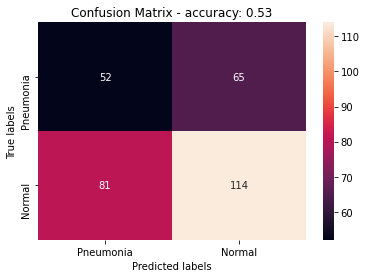

In [ ]:
# Evaluating the performance of an ImageNet-pretrained model

Imagenet_pretrained_vgg16 = Build_model(arch='vgg16', pretrained=True)
_ = Evaluate_model(Imagenet_pretrained_vgg16)

#Wait a second...
This says we are using a pre-trained model. Shouldn't that perform better than the untrained model? But it is 53% accurate (essentially random guessing) versus a slightly better 62% for untrained. What is going on here?
Well, what was the pre-trained model trained to do? 
#ImageNet
The pre-trained model was trained to perform well on the ImageNet challenge data. This is a large collection of photographs cantianing exactly 1 object such as a dog or cat or flower or ...  But there were no chest X-rays, let alone separate classes for pneumonia and normal. Hence the poor performance.
Does that mean we should only used pre-trained models for the task we are working on? You will learn the answer to that soon!


For now, we will start from scratch and work our way up to pre-trained models so you can best understand when and how to use them.

## Part 3: Training a deep learning model

In [ ]:
#BJE Probably should split this cell up and explain the pieces more

def Train_classifier(model: torch.nn.Module,
                     model_name: str, 
                     train_loader: Iterable, 
                     valid_loader: Iterable, 
                     criterion: Callable, 
                     optimizer: torch.optim, 
                     num_epochs: int,
                     plot_curves: bool):
  """
  Train a classifier model using pytorch and the given parameters.
  Parameters:
    model (Callable): any pytorch module,
    model_name (str): name of the model to be saved.
    train_loader (Iterable): dataloader for training data,
    valid_loader (Iterable): dataloader for validation data,
    criterion (Callable): any loss function, 
    optimizer (torch.optim): a pytorch optimizer,
    num_epochs (int): number of epochs to train the model,
    plot_charts (bool): whether or not to plot the training and validation loss
    and accuracy curves.
  """

  # Sending the model to device (preferably GPU)
  model.to(device)

  # Releaseing the GPU memory
  with torch.no_grad():
    torch.cuda.empty_cache()

  # Building a saving directory for models
  model_save_dir = os.path.join('Best_Models', model_name)
  if os.path.exists(model_save_dir):
    shutil.rmtree(model_save_dir)
  os.makedirs(model_save_dir, exist_ok=True)

  # lists to log the epoch values
  epoch_train_loss_list = list()
  epoch_train_accuracy_list = list()
  epoch_valid_loss_list = list()
  epoch_valid_accuracy_list = list()

  # Starting the training loop
  for epoch in range(1, num_epochs+1):
    print("-" * 20, f'\nStarting epoch: {epoch}/{num_epochs}')
    
    ## training
    model.train()
    steps_train_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(train_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      ### Zero the parameter gradients
      optimizer.zero_grad()

      ### Forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      ### Accumulating the loss and number of correct predictions in step
      steps_train_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch training loss and accuracy
    epoch_train_loss = steps_train_loss/ len(train_loader)
    epoch_train_loss_list.append(epoch_train_loss)
    epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
    epoch_train_accuracy_list.append(epoch_train_accuracy)

    ## validation
    model.eval()
    steps_valid_loss = 0.0
    steps_correct_predictions = 0

    for batch in tqdm(valid_loader, unit="batch"):
      inputs, labels = batch['image'].to(device), batch['label'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      ### Accumulating the loss and number of correct predictions in step
      steps_valid_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      steps_correct_predictions += (predicted == labels).sum().item()

    ## Measuring the epoch validation loss and accuracy
    epoch_valid_loss = steps_valid_loss/ len(valid_loader)
    epoch_valid_loss_list.append(epoch_valid_loss)
    epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
    epoch_valid_accuracy_list.append(epoch_valid_accuracy)
    
    ## Printing the logs
    print(f'train loss: {epoch_train_loss:.2f} | \
    train accuracy: {epoch_train_accuracy:.2f}')
    print(f'valid loss: {epoch_valid_loss:.2f} | \
    valid accuracy: {epoch_valid_accuracy:.2f}')

    ## Saving the best model
    if epoch==1:
      best_valid_loss = epoch_valid_loss
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
    elif epoch_valid_loss < best_valid_loss:
      weight_name = f'{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth'
      torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
      best_valid_loss = epoch_valid_loss

  # Printing the best model
  print(f'\nTrainng was over. The best model was: {weight_name}') 

  # Plotting the loss and accuracy curves
  if plot_curves:
    epoch_train_loss_list.insert(0, 0)
    epoch_train_accuracy_list.insert(0, 0)
    epoch_valid_loss_list.insert(0, 0)
    epoch_valid_accuracy_list.insert(0, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(epoch_train_loss_list, color='blue', label='training')
    axes[0].plot(epoch_valid_loss_list, color='orange', label='validation')
    axes[0].set_xlim(1, len(epoch_valid_loss_list)+1)
    axes[0].set_title('Loss curves')
    axes[0].legend()
    axes[1].plot(epoch_train_accuracy_list, color='blue', label='training')
    axes[1].plot(epoch_valid_accuracy_list, color='orange', label='validation')
    axes[1].set_xlim(1, len(epoch_train_accuracy_list)+1)
    axes[1].set_title('Accuracy curves')
    axes[1].legend();

  # Loading the best weights and returning the model
  model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
  return model

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.58 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.57 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.38 |     train accuracy: 0.83
valid loss: 0.52 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.16 |     train accuracy: 0.94
valid loss: 0.97 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.12 |     train accuracy: 0.96
valid loss: 0.93 |     valid accuracy: 0.77
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.10 |     train accuracy: 0.96
valid loss: 0.92 |     valid accuracy: 0.72
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.95 |     valid accuracy: 0.80
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.93 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.06 |     train accuracy: 0.98
valid loss: 0.94 |     valid accuracy: 0.78
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.06 |     train accuracy: 0.98
valid loss: 0.80 |     valid accuracy: 0.79

Trainng was over. The best model was: vgg16_model_1_Epoch3_ACC=0.7596153846153846.pth


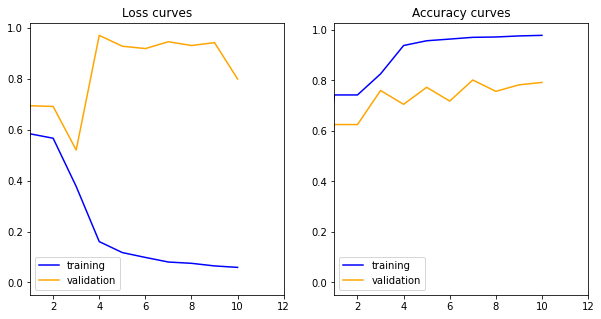

In [ ]:
# Doing a base-line training with a non-trained and not-pretrained model

vgg16_model_1 = Build_model(arch='vgg16', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(vgg16_model_1.parameters(), lr=learning_rate)
num_epochs = 10
vgg16_model_1 = Train_classifier(model=vgg16_model_1,
                                 model_name='vgg16_model_1', 
                                 train_loader=train_loader, 
                                 valid_loader=valid_loader, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

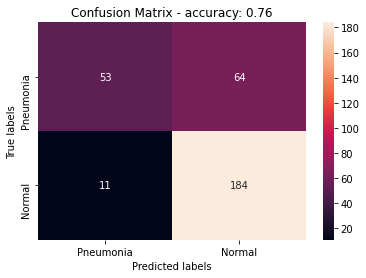

In [ ]:
# Evaluating the performance of vgg16_model_1 on the test set

_ = Evaluate_model(vgg16_model_1)

## Part 4: The concept of fit

### Under-fitting

#### Number of epochs

In [ ]:
# Under-fitting due to not enough training

vgg16_model_2 = Build_model(arch='vgg16', pretrained=False)
optimizer = torch.optim.SGD(vgg16_model_2.parameters(), lr=learning_rate)
num_epochs = 1
vgg16_model_2 = Train_classifier(model=vgg16_model_2,
                                 model_name='vgg16_model_2', 
                                 train_loader=train_loader, 
                                 valid_loader=valid_loader, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=False)

-------------------- 
Starting epoch: 1/1


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.58 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62

Trainng was over. The best model was: vgg16_model_2_Epoch1_ACC=0.625.pth


  0%|          | 0/39 [00:00<?, ?it/s]

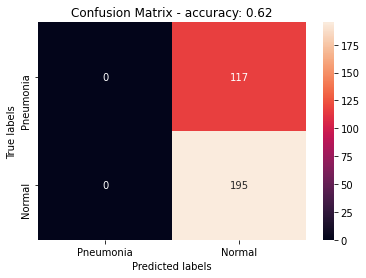

In [ ]:
# Evaluating the performance of vgg16_model_2 on the test set

_ = Evaluate_model(vgg16_model_2)

#### Learning rate adjustment

In [ ]:
# Under-fitting due to too small learning rate

vgg16_model_3 = Build_model(arch='vgg16', pretrained=False)
learning_rate = 0.0001
optimizer = torch.optim.SGD(vgg16_model_3.parameters(), lr=learning_rate)
num_epochs = 3
vgg16_model_3 = Train_classifier(model=vgg16_model_3,
                                 model_name='vgg16_model_3', 
                                 train_loader=train_loader, 
                                 valid_loader=valid_loader, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=False)

-------------------- 
Starting epoch: 1/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.68 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 2/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.68 |     train accuracy: 0.74
valid loss: 0.68 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/3


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.67 |     train accuracy: 0.74
valid loss: 0.68 |     valid accuracy: 0.62

Trainng was over. The best model was: vgg16_model_3_Epoch3_ACC=0.625.pth


#### Architecture selection

### Over-fitting

#### Collection of more training data

#### Early stopping and checkpointing

In [ ]:
# Demonstrate how to load a model in PyTorch. 

dummy_model = Build_model(arch='vgg16', pretrained=False)
weights_path = 'Best_Models/vgg16_model_1/vgg16_model_1_Epoch3_ACC=0.7596153846153846.pth'
dummy_model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
# Demonstrate how to save a model's weights in PyTorch. 

save_path = 'dummy_model.pth'
torch.save(dummy_model.state_dict(), save_path)

#### Data augmentation

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.58 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.57 |     train accuracy: 0.74
valid loss: 0.70 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.47 |     train accuracy: 0.78
valid loss: 0.42 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.20 |     train accuracy: 0.92
valid loss: 0.47 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.14 |     train accuracy: 0.95
valid loss: 0.80 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.12 |     train accuracy: 0.96
valid loss: 0.78 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.96
valid loss: 0.67 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.09 |     train accuracy: 0.97
valid loss: 0.73 |     valid accuracy: 0.78
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 1.40 |     valid accuracy: 0.74
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.51 |     valid accuracy: 0.81

Trainng was over. The best model was: vgg16_model_4_Epoch3_ACC=0.7916666666666666.pth


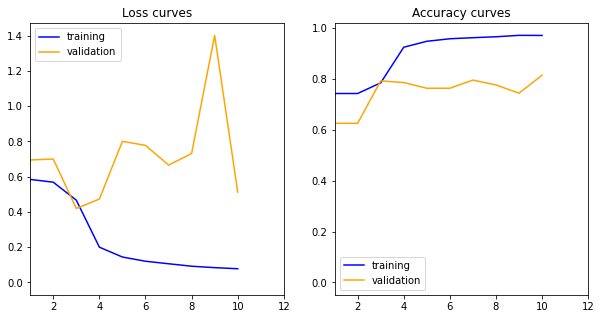

In [ ]:
# Demonstrating the performance of training with augmentation

train_loader2, valid_loader2, test_loader2 = Build_dataloaders(
    augment_train_data=True)

vgg16_model_4 = Build_model(arch='vgg16', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(vgg16_model_4.parameters(), lr=learning_rate)
num_epochs = 10
vgg16_model_4 = Train_classifier(model=vgg16_model_4,
                                 model_name='vgg16_model_4', 
                                 train_loader=train_loader2, 
                                 valid_loader=valid_loader2, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

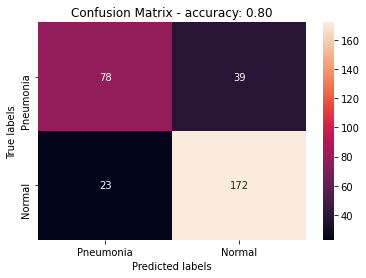

In [ ]:
# Evaluating the performance of vgg16_model_4 on the test set

_ = Evaluate_model(vgg16_model_4)

#### Regularization

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.58 |     train accuracy: 0.74
valid loss: 0.69 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.57 |     train accuracy: 0.74
valid loss: 0.70 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.55 |     train accuracy: 0.75
valid loss: 0.65 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.26 |     train accuracy: 0.89
valid loss: 0.41 |     valid accuracy: 0.82
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.16 |     train accuracy: 0.94
valid loss: 0.68 |     valid accuracy: 0.77
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.13 |     train accuracy: 0.95
valid loss: 0.80 |     valid accuracy: 0.74
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.96
valid loss: 0.65 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.10 |     train accuracy: 0.96
valid loss: 0.74 |     valid accuracy: 0.77
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.09 |     train accuracy: 0.97
valid loss: 1.48 |     valid accuracy: 0.73
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.53 |     valid accuracy: 0.81

Trainng was over. The best model was: vgg16_model_5_Epoch4_ACC=0.8205128205128205.pth


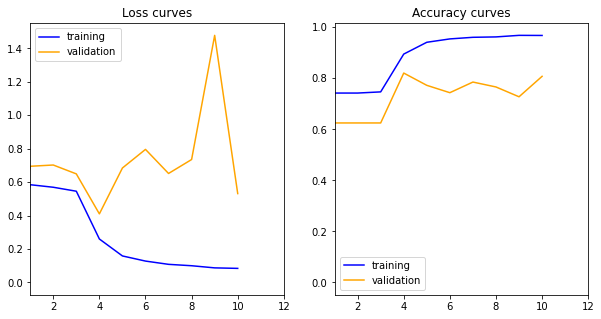

In [ ]:
# Training a model with L2 regularization

vgg16_model_5 = Build_model(arch='vgg16', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(vgg16_model_5.parameters(), lr=learning_rate, 
                            weight_decay=0.001)
num_epochs = 10
vgg16_model_5 = Train_classifier(model=vgg16_model_5,
                                 model_name='vgg16_model_5', 
                                 train_loader=train_loader2, 
                                 valid_loader=valid_loader2, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

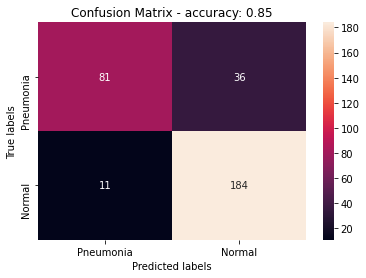

In [ ]:
# Evaluating the performance of vgg16_model_5 on the test set

_ = Evaluate_model(vgg16_model_5)

#### Architecture selection

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.49 |     train accuracy: 0.76
valid loss: 0.51 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.27 |     train accuracy: 0.90
valid loss: 0.60 |     valid accuracy: 0.74
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.19 |     train accuracy: 0.92
valid loss: 0.58 |     valid accuracy: 0.76
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.17 |     train accuracy: 0.94
valid loss: 0.59 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.13 |     train accuracy: 0.95
valid loss: 0.41 |     valid accuracy: 0.87
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.13 |     train accuracy: 0.95
valid loss: 1.02 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.96
valid loss: 0.51 |     valid accuracy: 0.83
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.10 |     train accuracy: 0.96
valid loss: 0.62 |     valid accuracy: 0.80
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.09 |     train accuracy: 0.97
valid loss: 1.28 |     valid accuracy: 0.72
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.09 |     train accuracy: 0.97
valid loss: 0.75 |     valid accuracy: 0.80

Trainng was over. The best model was: resnet18_model_1_Epoch5_ACC=0.8717948717948718.pth


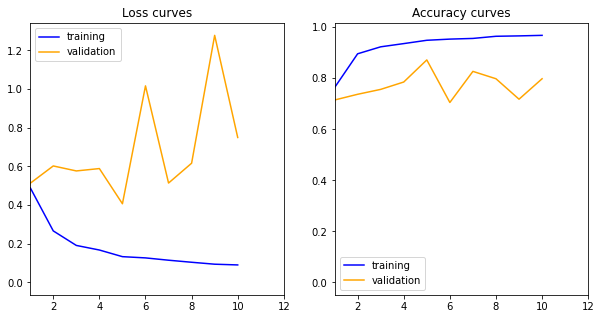

In [ ]:
# Training a model with resnet18 architecture

resnet18_model_1 = Build_model(arch='resnet18', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model_1.parameters(), lr=learning_rate, 
                            weight_decay=0.001)
num_epochs = 10
resnet18_model_1 = Train_classifier(model=resnet18_model_1,
                                 model_name='resnet18_model_1', 
                                 train_loader=train_loader2, 
                                 valid_loader=valid_loader2, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

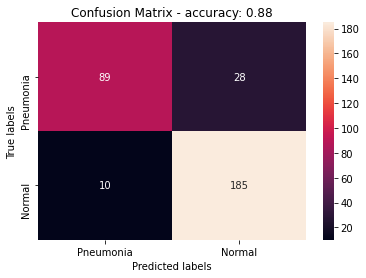

In [ ]:
# Evaluating the performance of resnet18_model_1 on the test set

_ = Evaluate_model(resnet18_model_1)

## Part 5: Transfer learning and fine tuning

### Easier fit

In [ ]:
# Defining a function to freeze the resnet models for fine-tunning

def Freeze_resnet18(resnet18_model: Callable, 
                    children_num_to_freeze: int = 5,
                    print_children: bool = False):
  """
  Freeze a resnet18 model up to a user-specified children mojule.
  Parameters:
    resnet18_model: The resnet18 model to be frozen and returned.
    children_num_to_freeze: The number of children modules to be frozen.
    print_children (bool): Whether or not to print the children modules.
  """
  for i, child in enumerate(resnet18_model.children()):
    if i < children_num_to_freeze:
      status = 'Frozen'
      for param in child.parameters():
        param.requires_grad = False
    else:
      status = 'Unfrozen'
      for param in child.parameters():
        param.requires_grad = True
    if print_children:
      print(f'******************* child module number: {i} - {status}')
      print(child)
  return resnet18_model

In [ ]:
# Creating a resnet18 model and freezing its inital layers.

resnet18_model_2 = Build_model(arch='resnet18', pretrained=True)
resnet18_model_2 = Freeze_resnet18(resnet18_model_2,
                                   children_num_to_freeze = 5,
                                   print_children=False)

-------------------- 
Starting epoch: 1/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.14 |     train accuracy: 0.95
valid loss: 0.40 |     valid accuracy: 0.88
-------------------- 
Starting epoch: 2/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.98
valid loss: 0.89 |     valid accuracy: 0.79
-------------------- 
Starting epoch: 3/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 0.60 |     valid accuracy: 0.88
-------------------- 
Starting epoch: 4/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 0.99
valid loss: 0.93 |     valid accuracy: 0.77
-------------------- 
Starting epoch: 5/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.02 |     train accuracy: 0.99
valid loss: 0.59 |     valid accuracy: 0.88
-------------------- 
Starting epoch: 6/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 0.88 |     valid accuracy: 0.84
-------------------- 
Starting epoch: 7/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 0.81 |     valid accuracy: 0.87
-------------------- 
Starting epoch: 8/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 0.91 |     valid accuracy: 0.86
-------------------- 
Starting epoch: 9/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 0.99
valid loss: 0.44 |     valid accuracy: 0.90
-------------------- 
Starting epoch: 10/10


  0%|          | 0/654 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.01 |     train accuracy: 1.00
valid loss: 1.21 |     valid accuracy: 0.79

Trainng was over. The best model was: resnet18_model_2_Epoch1_ACC=0.8846153846153846.pth


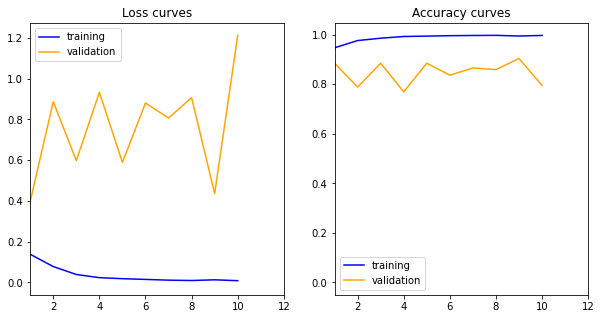

In [ ]:
# Training a model with resnet18 architecture and pretrained weights

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model_2.parameters(), lr=learning_rate, 
                            weight_decay=0.001)
num_epochs = 10
resnet18_model_2 = Train_classifier(model=resnet18_model_2,
                                 model_name='resnet18_model_2', 
                                 train_loader=train_loader2, 
                                 valid_loader=valid_loader2, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

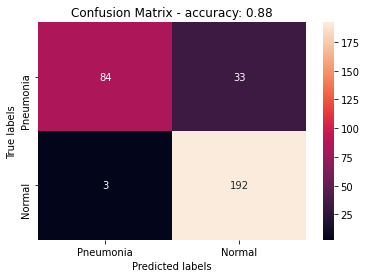

In [ ]:
# Evaluating the performance of resnet18_model_2 on the test set

_ = Evaluate_model(resnet18_model_2)

### Less data dependancy

In [ ]:
# Creating dataloaders with 10% of actual training data

train_loader3, valid_loader3, test_loader3 = Build_dataloaders(
    fct_to_train=0.1,
    augment_train_data=True)

-------------------- 
Starting epoch: 1/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.65 |     train accuracy: 0.74
valid loss: 0.66 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 2/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.59 |     train accuracy: 0.74
valid loss: 0.65 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 3/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.57 |     train accuracy: 0.74
valid loss: 0.64 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 4/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.53 |     train accuracy: 0.74
valid loss: 0.63 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 5/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.51 |     train accuracy: 0.74
valid loss: 0.68 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 6/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.47 |     train accuracy: 0.74
valid loss: 0.60 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 7/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.42 |     train accuracy: 0.75
valid loss: 0.62 |     valid accuracy: 0.62
-------------------- 
Starting epoch: 8/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.40 |     train accuracy: 0.77
valid loss: 0.56 |     valid accuracy: 0.74
-------------------- 
Starting epoch: 9/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.35 |     train accuracy: 0.85
valid loss: 0.54 |     valid accuracy: 0.75
-------------------- 
Starting epoch: 10/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.33 |     train accuracy: 0.87
valid loss: 0.52 |     valid accuracy: 0.72

Trainng was over. The best model was: resnet18_model_3_Epoch10_ACC=0.717948717948718.pth


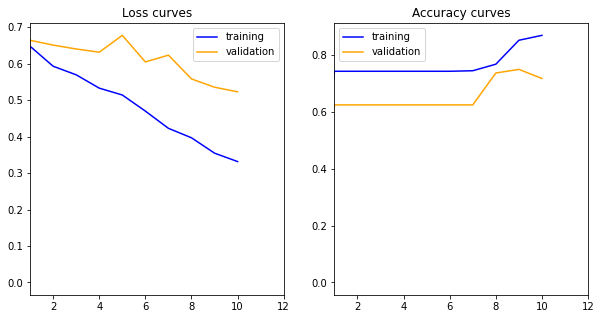

In [ ]:
# Creating and training resnet18 model without transfer learning

resnet18_model_3 = Build_model(arch='resnet18', pretrained=False)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model_3.parameters(), lr=learning_rate, 
                            weight_decay=0.001)
num_epochs = 10
resnet18_model_3 = Train_classifier(model=resnet18_model_3,
                                 model_name='resnet18_model_3', 
                                 train_loader=train_loader3, 
                                 valid_loader=valid_loader3, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

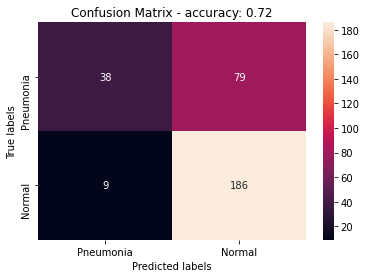

In [ ]:
# Evaluating the performance of resnet18_model_3 on the test set

_ = Evaluate_model(resnet18_model_3)

In [ ]:
# Creating a resnet18 model and freezing its inital layers

resnet18_model_4 = Build_model(arch='resnet18', pretrained=True)
resnet18_model_4 = Freeze_resnet18(resnet18_model_4,
                                   children_num_to_freeze = 5,
                                   print_children=False)

-------------------- 
Starting epoch: 1/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.29 |     train accuracy: 0.85
valid loss: 0.36 |     valid accuracy: 0.86
-------------------- 
Starting epoch: 2/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.21 |     train accuracy: 0.93
valid loss: 1.87 |     valid accuracy: 0.44
-------------------- 
Starting epoch: 3/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.12 |     train accuracy: 0.96
valid loss: 0.52 |     valid accuracy: 0.87
-------------------- 
Starting epoch: 4/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.07 |     train accuracy: 0.98
valid loss: 0.68 |     valid accuracy: 0.81
-------------------- 
Starting epoch: 5/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.08 |     train accuracy: 0.97
valid loss: 0.66 |     valid accuracy: 0.82
-------------------- 
Starting epoch: 6/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.98
valid loss: 0.63 |     valid accuracy: 0.84
-------------------- 
Starting epoch: 7/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.99
valid loss: 0.43 |     valid accuracy: 0.89
-------------------- 
Starting epoch: 8/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.04 |     train accuracy: 0.98
valid loss: 0.85 |     valid accuracy: 0.80
-------------------- 
Starting epoch: 9/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.03 |     train accuracy: 0.99
valid loss: 1.62 |     valid accuracy: 0.71
-------------------- 
Starting epoch: 10/10


  0%|          | 0/66 [00:00<?, ?batch/s]

  0%|          | 0/39 [00:00<?, ?batch/s]

train loss: 0.11 |     train accuracy: 0.99
valid loss: 0.38 |     valid accuracy: 0.88

Trainng was over. The best model was: resnet18_model_4_Epoch1_ACC=0.8589743589743589.pth


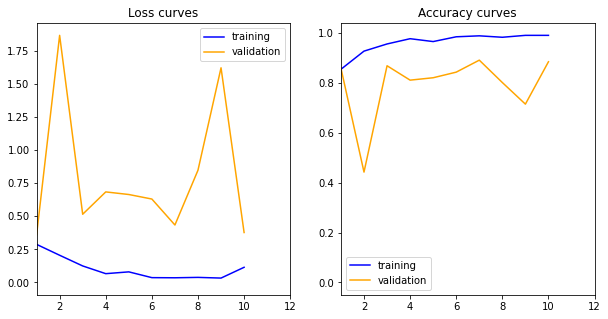

In [ ]:
# Fine tunning the resnet18 model with pretrained weights on
# a small training dataset

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(resnet18_model_4.parameters(), lr=learning_rate, 
                            weight_decay=0.001)
num_epochs = 10
resnet18_model_4 = Train_classifier(model=resnet18_model_4,
                                 model_name='resnet18_model_4', 
                                 train_loader=train_loader3, 
                                 valid_loader=valid_loader3, 
                                 criterion=criterion, 
                                 optimizer=optimizer, 
                                 num_epochs=num_epochs, 
                                 plot_curves=True)

  0%|          | 0/39 [00:00<?, ?it/s]

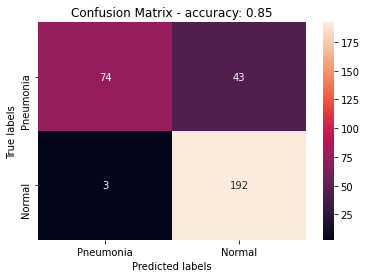

In [ ]:
# Evaluating the performance of resnet18_model_4 on the test set

_ = Evaluate_model(resnet18_model_4)

## Part 6: Conclusion and further reading

## Part 7: References